### Step 1 - Examine the Dataset

In this file, we examine the application_train dataset, which contains the majority of the data about our applicants.  It's comprised of 307,511 rows and 122 columns.  I created a number of helper functions to give us an overview of each field, including both a visualization and some basic statistical analysis.

As part of the analysis, we bucket features into categories for future preprocessing: 
- Non-Numeric features get one-hot encoded
- log-transform features get a log transformation before being treated as numeric features
- numeric features get scaled to a uniform range
- string_to_bool features substitute 1/0 for equivalent string designations (Yes/No, True/False, T/F, etc.)

Because the workbook is so long, we export our feature categorizations into data/tmp at the end of the run and import those in the preprocessing workbook.  No persistent pre-processing happens here, because I wanted to be able to process both the application_train dataset (which is labeled) and the application_test dataset (which is the unlabeled test set used for the Kaggle competition)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

# Show all of the data in a dataframe
pd.set_option('display.max_columns', None)

### Load Data

In [2]:
# Training Set
application_train = pd.read_csv('data/application_train.csv')
print("Loaded Training Set: {0} rows {1} columns".format(application_train.shape[0], application_train.shape[1]))

columns = pd.read_csv('data/HomeCredit_columns_description.csv')

Loaded Training Set: 307511 rows 122 columns


In [3]:
non_numeric_features = []    # non-numeric features for one-hot encoding
numeric_features = []        # numeric features (for feature scaling)
string_to_bool_features = [] # boolean features (that need conversion from string to binary)
log_transform_features = []  # skewed features that need log transformation

### Inspect Data

#### Application Data

In [4]:
display(application_train.head(n=10))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Utility Functions

In [5]:
# Visualize the contents of a non-numeric column

def explore_non_numeric(field, showDetails=True):

    # Inspired By: 
    # https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array

    unique, counts = np.unique(field, return_counts=True)
    total_records = np.size(field)

    if (showDetails): 
        i = 0
        while i < np.size(unique): 
            percentage = (counts[i] / total_records) * 100
            print("Value: {0} Count: {1} Percentage: {2}".format(unique[i], counts[i], percentage))
            i += 1

    # Example code from: https://matplotlib.org/examples/pie_and_polar_charts/pie_demo_features.html
    fig1, ax1 = plt.subplots()
    ax1.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [6]:
# Visualize the contents of a numeric column

def explore_numeric(field, showUnique=False, graphType="dist", bins=20, showMeanLines=True):     
    mean = np.mean(field)
    avg = np.average(field)
    
    # Take a look at the range
    print("Max: {0} Min: {1} Mean: {2} Avg: {3} Std: {4}".format(
    np.max(field),
    np.min(field),
    mean,
    avg,
    np.std(field)))

    # Unique Values
    # print("Values: {0}".format(application_train['CNT_CHILDREN'].unique()))

    if (showUnique): 
    
        unique, counts = np.unique(application_train['CNT_CHILDREN'], return_counts=True)
        total_records = np.size(application_train['CNT_CHILDREN'])

        i = 0
        while i < np.size(unique): 
            percentage = (counts[i] / total_records) * 100
            print("Value: {0} Count: {1} Percentage: {2}".format(unique[i], counts[i], percentage))
            i += 1

    # Examine distribution
    plt.figure(figsize=(15,10))
    plt.title("Distribution Graph")
    if (showMeanLines):
        plt.axvline(avg, color="red")    # Plot the average
        plt.axvline(mean, color="green") # Plot the mean
    
    if (graphType == "hist"): 
        sns.distplot(field,bins=bins)
    else: 
        sns.distplot(field)

#### TARGET

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

Value: 0 Count: 282686 Percentage: 91.92711805431351
Value: 1 Count: 24825 Percentage: 8.072881945686495


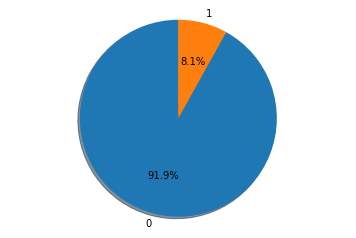

In [7]:
explore_non_numeric(application_train['TARGET'])

#### CODE_GENDER
Gender of the client

Value: F Count: 202448 Percentage: 65.83439291602576
Value: M Count: 105059 Percentage: 34.164306317497584
Value: XNA Count: 4 Percentage: 0.0013007664766463637


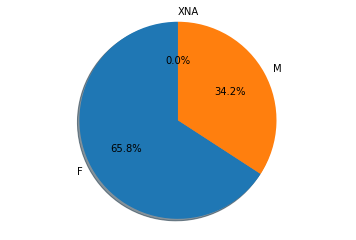

In [8]:
explore_non_numeric(application_train['CODE_GENDER'])

# Categorize it for one-hot encoding later
non_numeric_features.append('CODE_GENDER')

#### NAME_CONTRACT_TYPE
Identification if loan is cash or revolving

Value: Cash loans Count: 278232 Percentage: 90.47871458256778
Value: Revolving loans Count: 29279 Percentage: 9.521285417432223


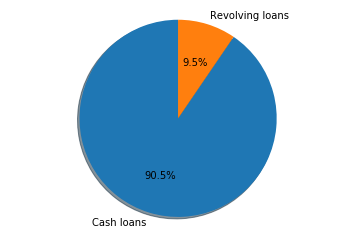

In [9]:
explore_non_numeric(application_train['NAME_CONTRACT_TYPE'])

# Categorize it for one-hot encoding later
non_numeric_features.append('NAME_CONTRACT_TYPE')

#### FLAG_OWN_CAR

Flag if the client owns a car

Value: N Count: 202924 Percentage: 65.98918412674668
Value: Y Count: 104587 Percentage: 34.010815873253314


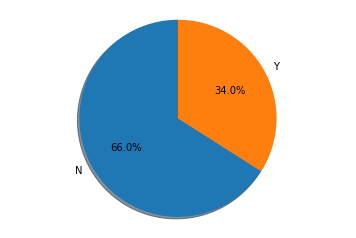

In [10]:
explore_non_numeric(application_train['FLAG_OWN_CAR'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

Value: 0 Count: 202924 Percentage: 65.98918412674668
Value: 1 Count: 104587 Percentage: 34.010815873253314


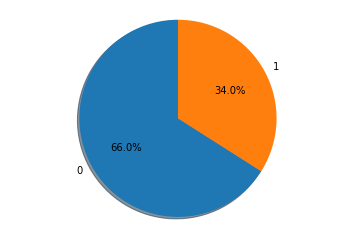

In [11]:
lb = LabelBinarizer()
bool_own_car = lb.fit_transform(application_train['FLAG_OWN_CAR'])

explore_non_numeric(bool_own_car)

string_to_bool_features.append("FLAG_OWN_CAR")

#### FLAG_OWN_REALTY

Flag if client owns a house or flat

Value: N Count: 94199 Percentage: 30.632725333402703
Value: Y Count: 213312 Percentage: 69.3672746665973


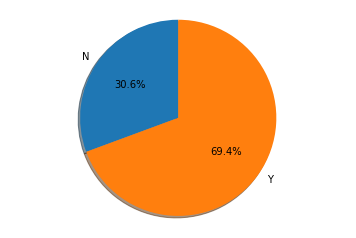

In [12]:
explore_non_numeric(application_train['FLAG_OWN_REALTY'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

Value: 0 Count: 94199 Percentage: 30.632725333402703
Value: 1 Count: 213312 Percentage: 69.3672746665973


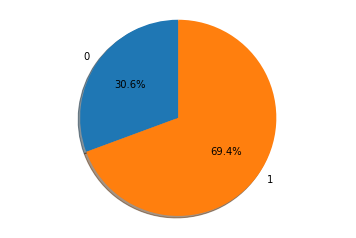

In [13]:
lb = LabelBinarizer()
bool_own_realty = lb.fit_transform(application_train['FLAG_OWN_REALTY'])

explore_non_numeric(bool_own_realty)

string_to_bool_features.append('FLAG_OWN_REALTY')

### CNT_CHILDREN
Number of children the client has

Max: 19 Min: 0 Mean: 0.4170517477423572 Avg: 0.4170517477423572 Std: 0.7221202102975595


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


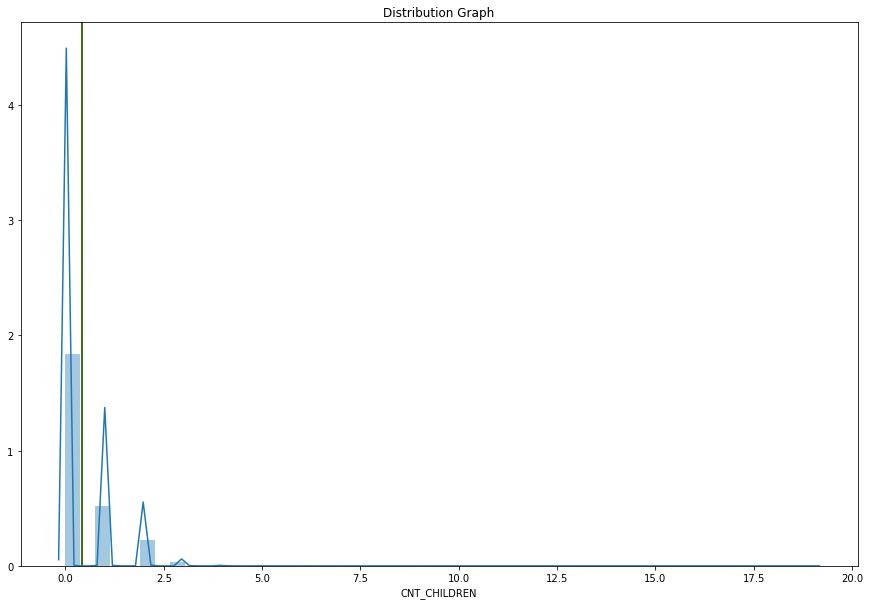

In [14]:
explore_numeric(application_train['CNT_CHILDREN'])   

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. 

Max: 2.995732273553991 Min: 0.0 Mean: 0.25311615347965405 Avg: 0.25311615347965405 Std: 0.40593657676776573


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


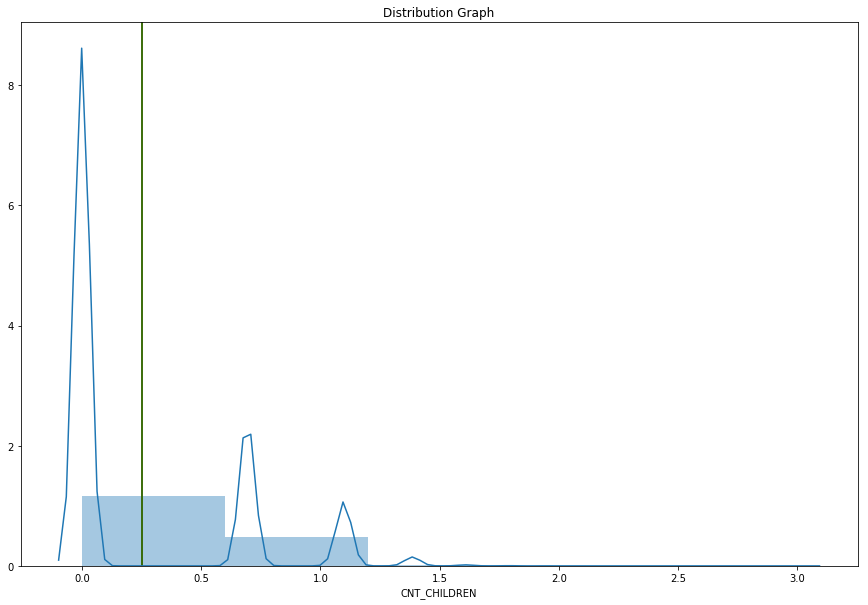

In [15]:
cnt_children = application_train['CNT_CHILDREN']
cnt_children_transformed = cnt_children.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(cnt_children_transformed, graphType="hist", bins=5)

# I think outlier removal might be a better way to handle this
numeric_features.append('CNT_CHILDREN')
#log_transform_features.append('CNT_CHILDREN')



##### AMT_INCOME_TOTAL
Income of the client

Max: 117000000.0 Min: 25650.0 Mean: 168797.9192969845 Avg: 168797.9192969845 Std: 237122.7607262434


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


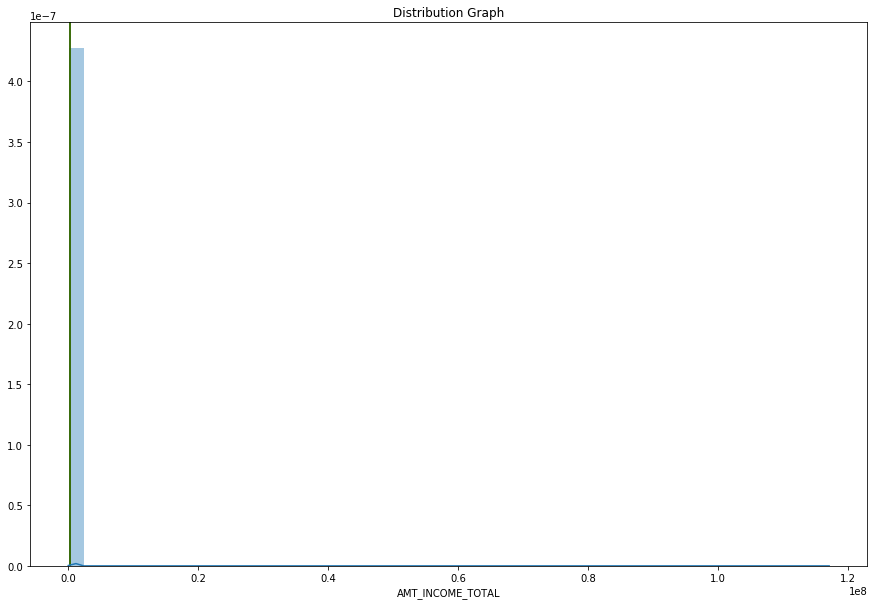

In [16]:
explore_numeric(application_train['AMT_INCOME_TOTAL'])

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

Max: 18.57768450130904 Min: 10.152337836193743 Mean: 11.909245341906919 Avg: 11.909245341906919 Std: 0.4889056656307125


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


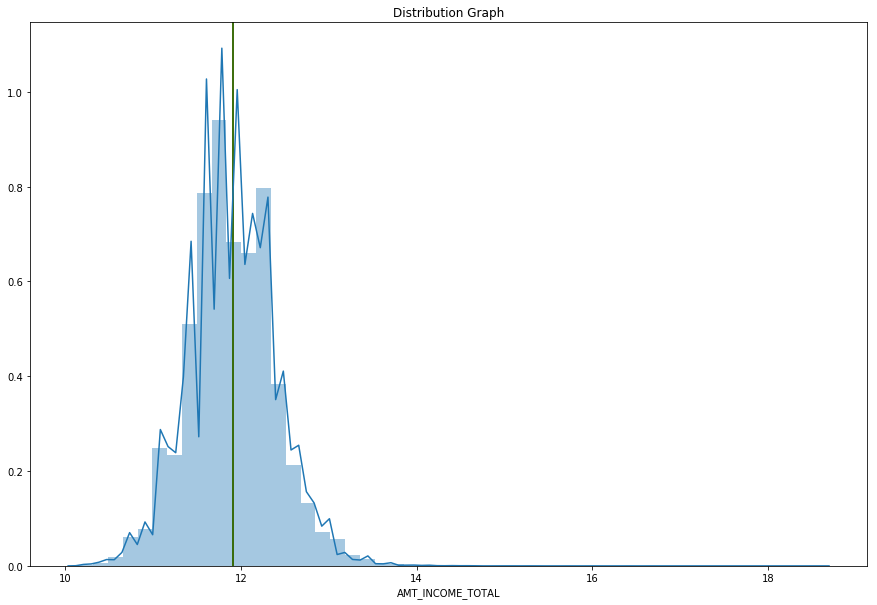

In [17]:
income_total = application_train['AMT_INCOME_TOTAL']
income_total_transformed = income_total.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(income_total_transformed)

# Let's just try this with outlier removal
numeric_features.append('AMT_INCOME_TOTAL')

#log_transform_features.append('AMT_INCOME_TOTAL')

#### AMT_CREDIT
Credit amount of the loan

Max: 4050000.0 Min: 45000.0 Mean: 599025.9997057016 Avg: 599025.9997057016 Std: 402490.1225621855


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


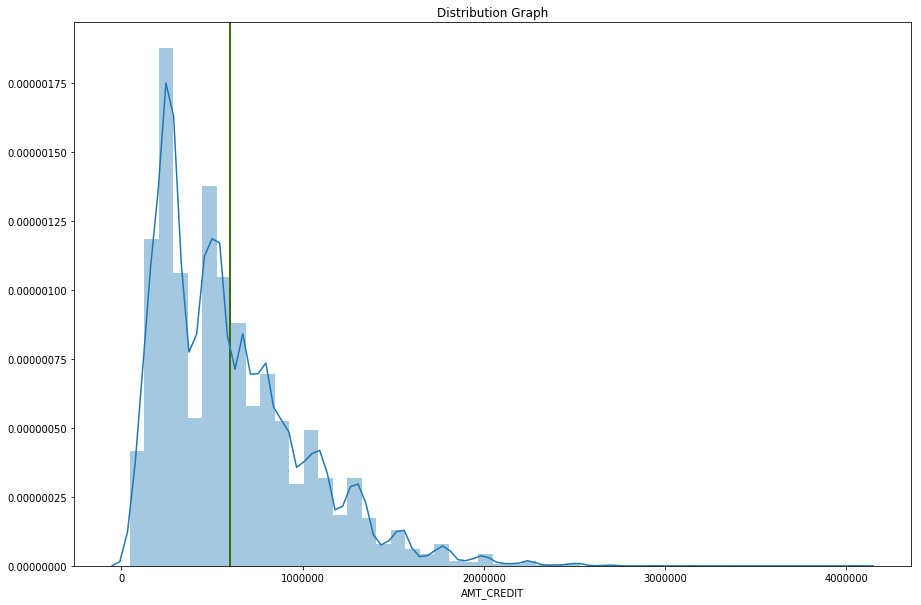

In [18]:
explore_numeric(application_train['AMT_CREDIT'])

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 15.214227685996272 Min: 10.714439990727769 Mean: 13.070108059483369 Avg: 13.070108059483369 Std: 0.715192195840206


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


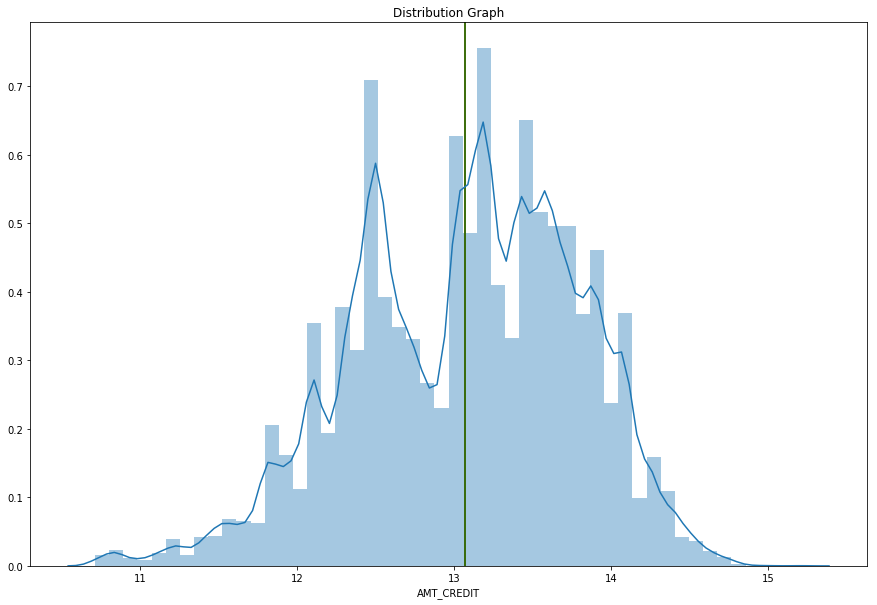

In [19]:
credit_total = application_train['AMT_CREDIT']
credit_total_transformed = credit_total.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(credit_total_transformed)


numeric_features.append('AMT_CREDIT')

#log_transform_features.append('AMT_CREDIT')

#### AMT_ANNUITY
Loan annuity

Max: 258025.5 Min: 0.0 Mean: 27107.516051458322 Avg: 27107.516051458322 Std: 14494.420189549066


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


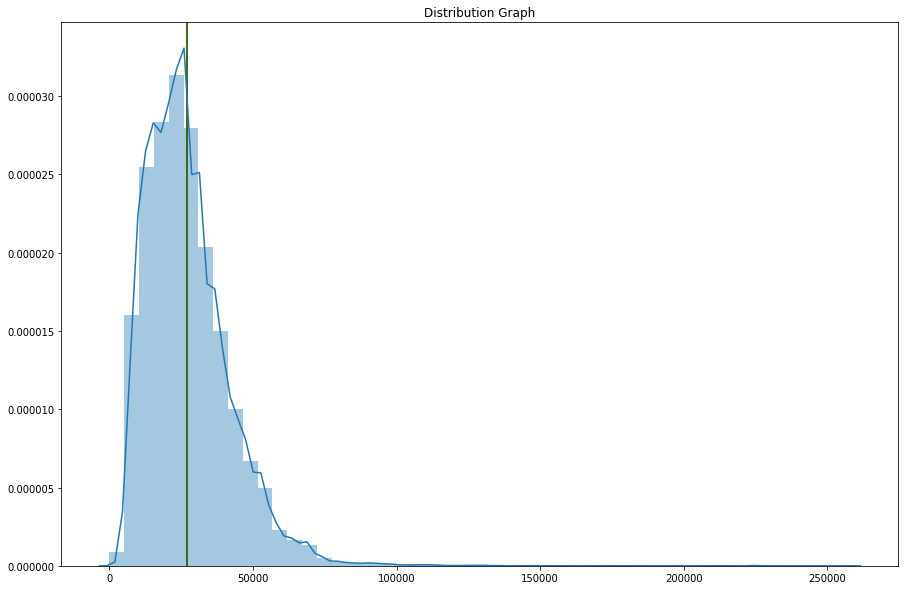

In [20]:
# Convert Non-Numerics
amt_annuity = np.nan_to_num(application_train['AMT_ANNUITY'], copy=True)
explore_numeric(amt_annuity)

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 12.460817571807413 Min: 0.0 Mean: 10.067281762604763 Avg: 10.067281762604763 Std: 0.5494814442293304


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


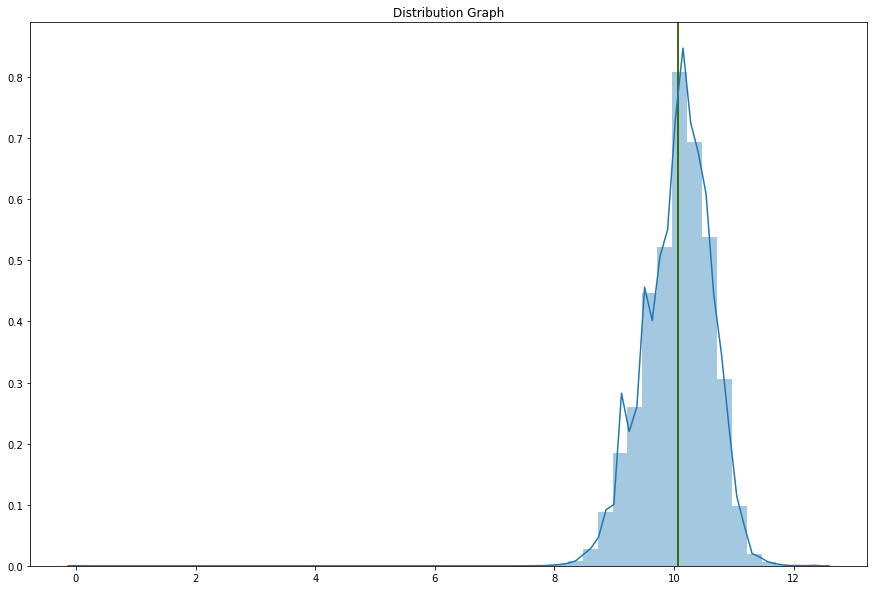

In [21]:
annuity = application_train['AMT_ANNUITY']
annuity_transformed = annuity.apply(lambda x: np.log(x + 1))
annuity_transformed_numeric = np.nan_to_num(annuity_transformed, copy=True)

#visualize the new distribution
explore_numeric(annuity_transformed_numeric)

numeric_features.append('AMT_ANNUITY')
#log_transform_features.append('AMT_ANNUITY')

#### AMT_GOODS_PRICE
For consumer loans it is the price of the goods for which the loan is given

Max: 4050000.0 Min: 0.0 Mean: 537909.4796511345 Avg: 537909.4796511345 Std: 369633.15163863753


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


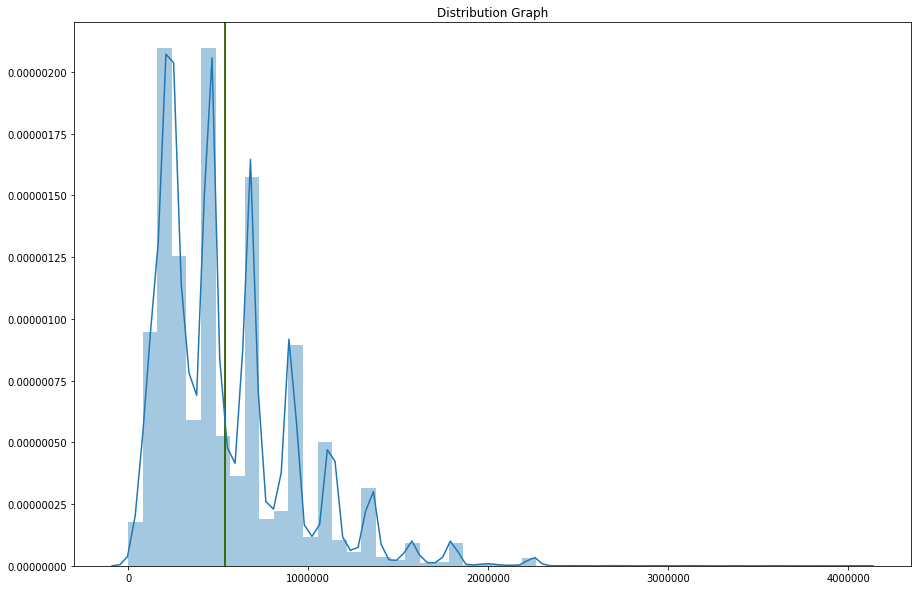

In [22]:
# Convert Non-Numerics
amt_goods_price = np.nan_to_num(application_train['AMT_GOODS_PRICE'], copy=True)
explore_numeric(amt_goods_price)

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 15.214227685996272 Min: 0.0 Mean: 12.948770745519909 Avg: 12.948770745519909 Std: 0.8143825559555455


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


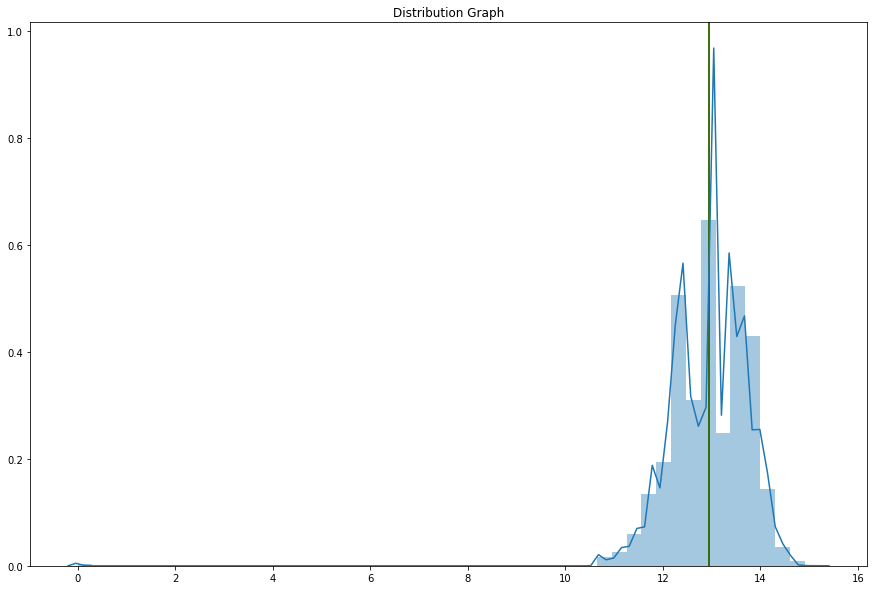

In [23]:
goods_price = application_train['AMT_GOODS_PRICE']
goods_price_transformed = goods_price.apply(lambda x: np.log(x + 1))
goods_price_transformed_numeric = np.nan_to_num(goods_price_transformed, copy=True)

#visualize the new distribution
explore_numeric(goods_price_transformed_numeric)

numeric_features.append('AMT_GOODS_PRICE')
#log_transform_features.append('AMT_GOODS_PRICE')

#### NAME_TYPE_SUITE
Who was accompanying client when he was applying for the loan

Value: Children Count: 3267 Percentage: 1.0624010198009177
Value: Family Count: 40149 Percentage: 13.056118317718715
Value: Group of people Count: 271 Percentage: 0.08812692879279115
Value: Other_A Count: 866 Percentage: 0.2816159421939378
Value: Other_B Count: 1770 Percentage: 0.575589165916016
Value: Spouse, partner Count: 11370 Percentage: 3.697428709867289
Value: Unaccompanied Count: 248526 Percentage: 80.81857234375356
Value: missing Count: 1292 Percentage: 0.42014757195677555


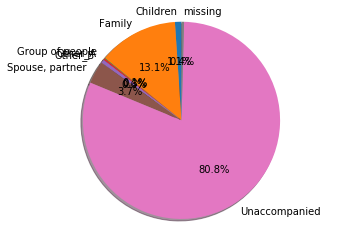

In [24]:
# Replace any nans with a string for easier encoding
# https://stackoverflow.com/questions/43066071/replace-numpy-nan-with-string-in-list-with-strings
name_type_suite = ['missing' if x is np.nan else x for x in application_train['NAME_TYPE_SUITE']]

explore_non_numeric(name_type_suite)

# Replace original data with modified data
application_train['NAME_TYPE_SUITE_NORMALIZED'] = name_type_suite
result = application_train.drop('NAME_TYPE_SUITE',axis=1)

# One-Hot Encode This Later
non_numeric_features.append('NAME_TYPE_SUITE')

#### NAME_INCOME_TYPE
Clients income type (businessman, working, maternity leave)

Value: Businessman Count: 10 Percentage: 0.0032519161916159094
Value: Commercial associate Count: 71617 Percentage: 23.28924818949566
Value: Maternity leave Count: 5 Percentage: 0.0016259580958079547
Value: Pensioner Count: 55362 Percentage: 18.003258420024
Value: State servant Count: 21703 Percentage: 7.057633710664009
Value: Student Count: 18 Percentage: 0.005853449144908637
Value: Unemployed Count: 22 Percentage: 0.007154215621555002
Value: Working Count: 158774 Percentage: 51.63197414076245


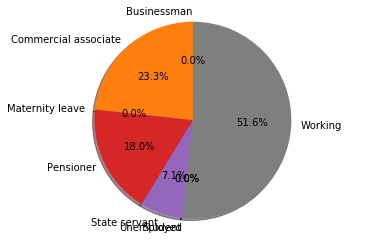

In [25]:
explore_non_numeric(application_train['NAME_INCOME_TYPE'])

# One-Hot Encode This Later
non_numeric_features.append("NAME_INCOME_TYPE")

#### NAME_EDUCATION_TYPE
Level of highest education the client achieved

Value: Academic degree Count: 164 Percentage: 0.053331425542500914
Value: Higher education Count: 74863 Percentage: 24.344820185294186
Value: Incomplete higher Count: 10277 Percentage: 3.3419942701236702
Value: Lower secondary Count: 3816 Percentage: 1.2409312187206312
Value: Secondary / secondary special Count: 218391 Percentage: 71.01892290031901


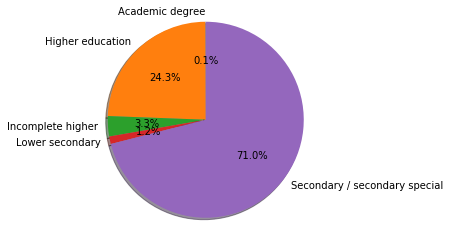

In [26]:
explore_non_numeric(application_train['NAME_EDUCATION_TYPE'])

# One-Hot Encode This Later
non_numeric_features.append("NAME_EDUCATION_TYPE")

#### NAME_FAMILY_STATUS
Family status of the client

Value: Civil marriage Count: 29775 Percentage: 9.68258046053637
Value: Married Count: 196432 Percentage: 63.87804013514964
Value: Separated Count: 19770 Percentage: 6.429038310824653
Value: Single / not married Count: 45444 Percentage: 14.77800794117934
Value: Unknown Count: 2 Percentage: 0.0006503832383231819
Value: Widow Count: 16088 Percentage: 5.231682769071676


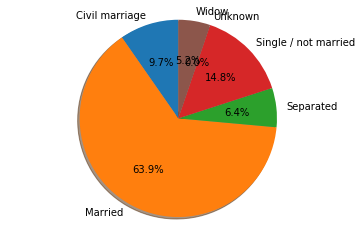

In [27]:
explore_non_numeric(application_train['NAME_FAMILY_STATUS'])

# One-Hot Encode This Later
non_numeric_features.append("NAME_FAMILY_STATUS")

#### NAME_HOUSING_TYPE
What is the housing situation of the client (renting, living with parents, ...)

Value: Co-op apartment Count: 1122 Percentage: 0.36486499669930506
Value: House / apartment Count: 272868 Percentage: 88.73438673738501
Value: Municipal apartment Count: 11183 Percentage: 3.636617877084072
Value: Office apartment Count: 2617 Percentage: 0.8510264673458836
Value: Rented apartment Count: 4881 Percentage: 1.5872602931277255
Value: With parents Count: 14840 Percentage: 4.82584362835801


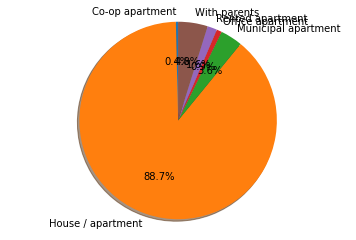

In [28]:
explore_non_numeric(application_train['NAME_HOUSING_TYPE'])

# One-Hot Encode This Later
non_numeric_features.append("NAME_HOUSING_TYPE")

#### REGION_POPULATION_RELATIVE
Normalized population of region where client lives (higher number means the client lives in more populated region)

Max: 0.072508 Min: 0.00029 Mean: 0.020868112057780042 Avg: 0.020868112057780042 Std: 0.013831257633604526


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


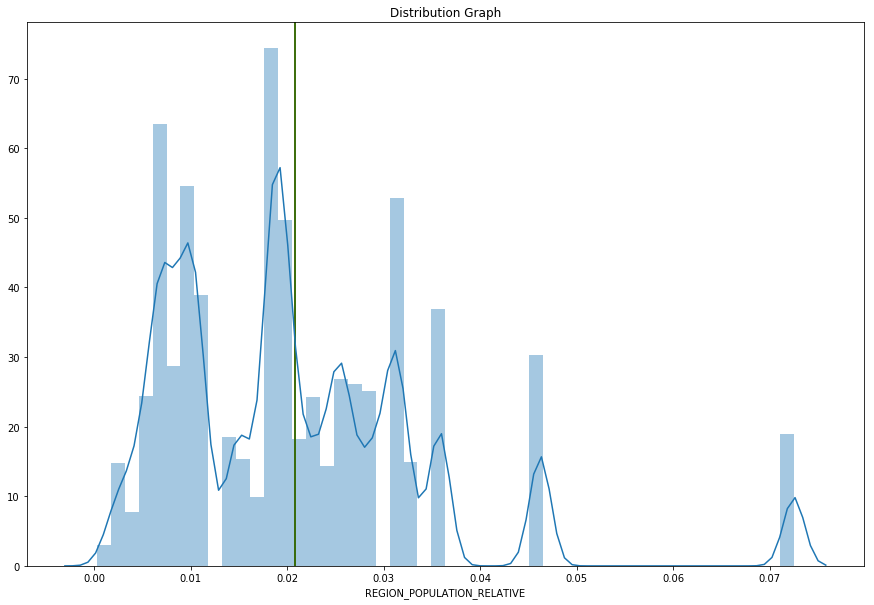

In [29]:
explore_numeric(application_train['REGION_POPULATION_RELATIVE'])

# Add to our list of numeric features so that we scale the values appropriately later
numeric_features.append('REGION_POPULATION_RELATIVE')

#### DAYS_BIRTH
Client's age in days, [subtracted from] at the time of application

Max: -7489 Min: -25229 Mean: -16036.995066843137 Avg: -16036.995066843137 Std: 4363.981536117146


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


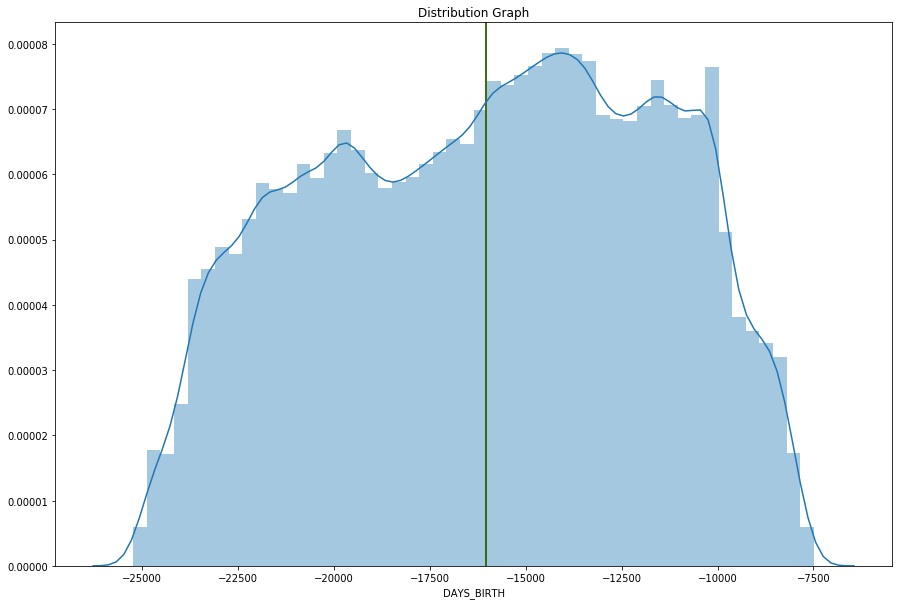

In [30]:
explore_numeric(application_train['DAYS_BIRTH'])

# Add to our list of numeric features so that we scale the values appropriately later
numeric_features.append('DAYS_BIRTH')

#### DAYS_EMPLOYED
How many days before the application the person started current employment

Max: 365243 Min: -17912 Mean: 63815.04590404896 Avg: 63815.04590404896 Std: 141275.53681006416


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


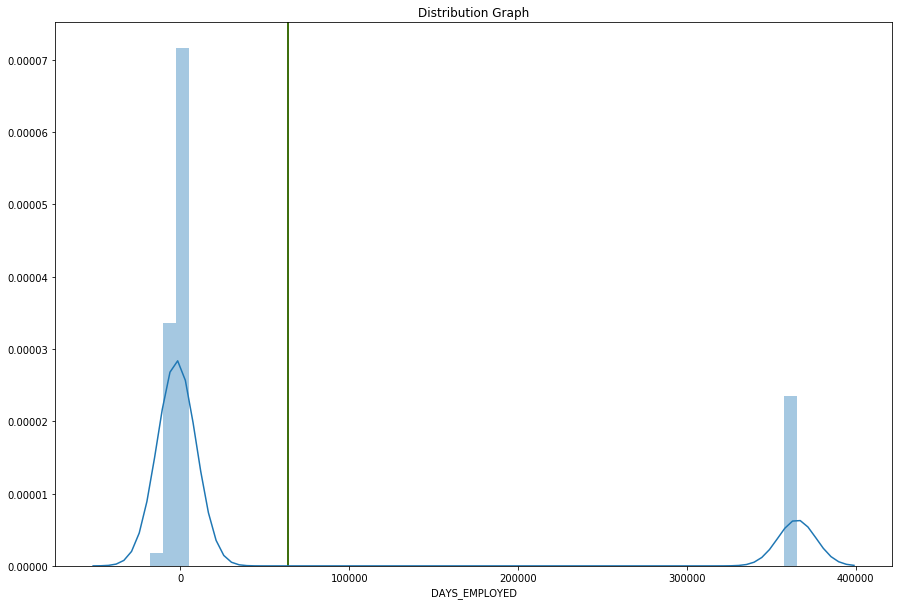

In [31]:
explore_numeric(application_train['DAYS_EMPLOYED'])

#### Preprocessing: 
There's a large body of outliers that indicate that someone has worked ~100 years.  This is clearly wrong.  Also, I don't expect this field to be normally distributed (I think you'd see a decreasing number of people employed in the same role over time and a body of people with no job or no work history), so doing a log transformation seems inappropriate.


Max: 0 Min: -17912 Mean: -1954.8481225061869 Avg: -1954.8481225061869 Std: 2307.065145271043


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


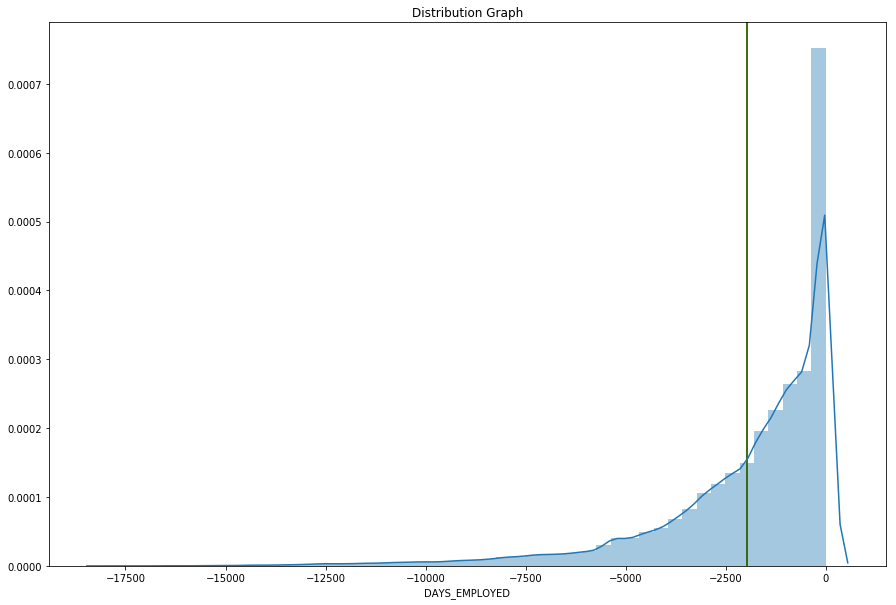

In [32]:
days_employed = application_train['DAYS_EMPLOYED']

# A bunch of records indicate that the person has worked for ~100 years.
# We'll need to replace those
days_employed = days_employed.replace({365243: 0})

#visualize the new distribution
explore_numeric(days_employed)

# Swap the normalized data with the original field
application_train['DAYS_EMPLOYED_TRANSFORMED'] = days_employed
result = application_train.drop('DAYS_EMPLOYED',axis=1)

# Add to our list of numeric features so that we scale the values appropriately later
numeric_features.append('DAYS_EMPLOYED')

#### DAYS_REGISTRATION
How many days before the application did client change his registration

Max: 0.0 Min: -24672.0 Mean: -4986.120327538419 Avg: -4986.120327538419 Std: 3522.8805928928805


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


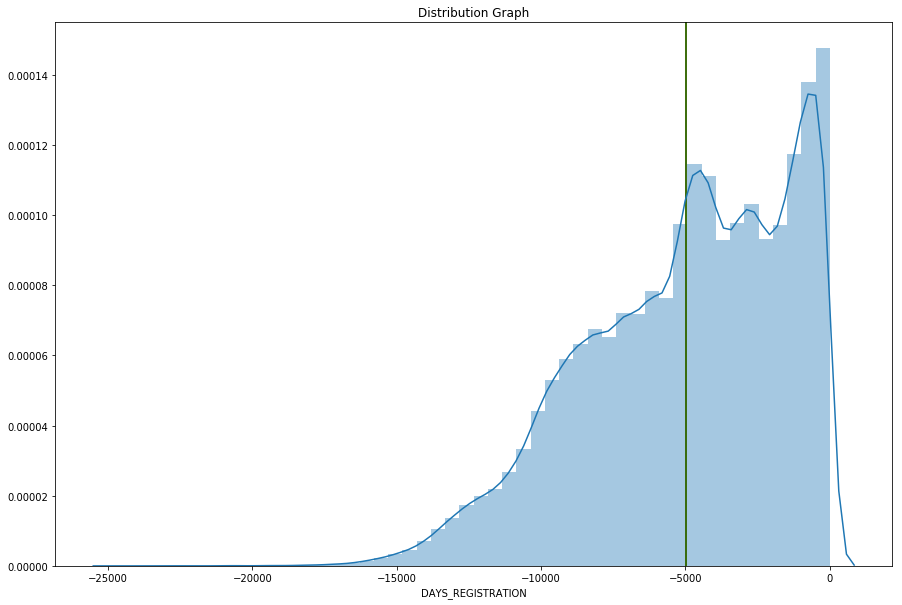

In [33]:
explore_numeric(application_train['DAYS_REGISTRATION'])
numeric_features.append('DAYS_REGISTRATION')

#### DAYS_ID_PUBLISH
How many days before the application did client change the identity document with which he applied for the loan

In [34]:
days_id_publish = application_train['DAYS_ID_PUBLISH']
numeric_features.append('DAYS_ID_PUBLISH')

#### OWN_CAR_AGE
Age of client's car

Max: 0    91.0
dtype: float64 Min: 0    0.0
dtype: float64 Mean: 0    4.101879
dtype: float64 Avg: 4.101879282367134 Std: 0    9.009499
dtype: float64


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


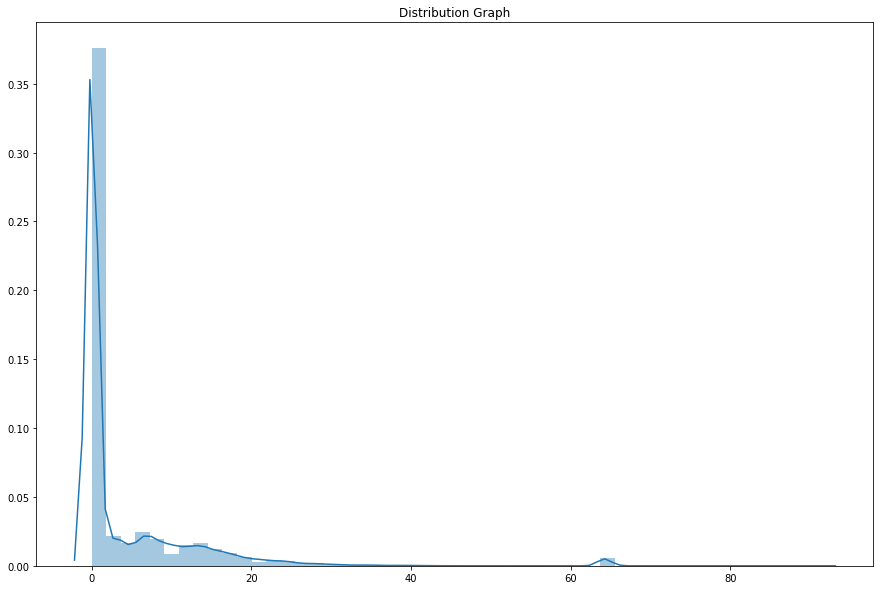

In [35]:
own_car_age = application_train['OWN_CAR_AGE']
own_car_age_numeric = np.nan_to_num(application_train['OWN_CAR_AGE'])
own_car_age_numeric = pd.DataFrame(data=own_car_age_numeric)
explore_numeric(own_car_age_numeric, showMeanLines=False)

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks more normally distributed, and I think the high representation of people with new or no cars is more reasonable.

Max: 0    4.521789
dtype: float64 Min: 0    0.0
dtype: float64 Mean: 0    0.763979
dtype: float64 Avg: 0.7639788625473312 Std: 0    1.168945
dtype: float64


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


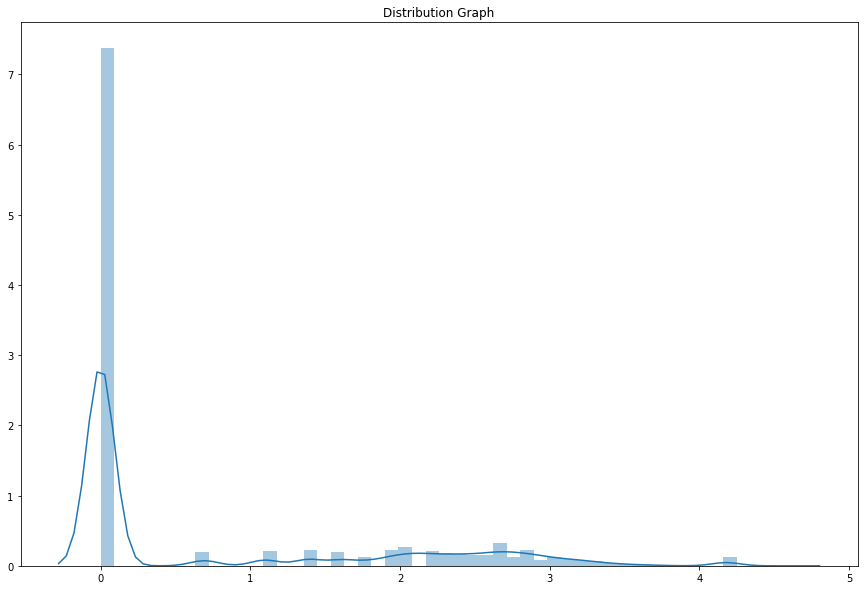

In [36]:
own_car_age_numeric_transformed = own_car_age_numeric.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(own_car_age_numeric_transformed, showMeanLines=False)

numeric_features.append('OWN_CAR_AGE')
#log_transform_features.append('OWN_CAR_AGE')

#### FLAG_MOBIL
Did client provide mobile phone (1=YES, 0=NO)

Value: 0 Count: 1 Percentage: 0.00032519161916159093
Value: 1 Count: 307510 Percentage: 99.99967480838083


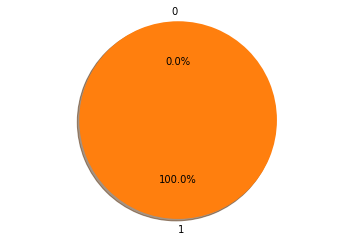

In [37]:
explore_non_numeric(application_train['FLAG_MOBIL'])

NOTE: Given the fact that 99.999% of people have a cellphone, we can drop this feature.  It has no value in terms of differentiation.

#### FLAG_EMP_PHONE

Did client provide work phone (1=YES, 0=NO)

Value: 0 Count: 55386 Percentage: 18.011063018883878
Value: 1 Count: 252125 Percentage: 81.98893698111613


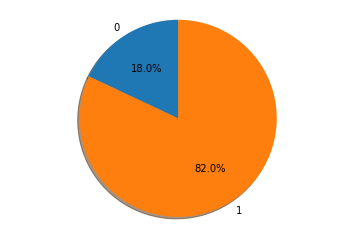

In [38]:
explore_non_numeric(application_train['FLAG_EMP_PHONE'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

Value: 0 Count: 55386 Percentage: 18.011063018883878
Value: 1 Count: 252125 Percentage: 81.98893698111613


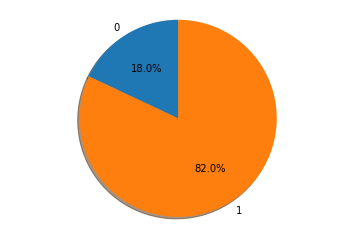

In [39]:
lb = LabelBinarizer()
bool_emp_phone = lb.fit_transform(application_train['FLAG_EMP_PHONE'])

explore_non_numeric(bool_emp_phone)

string_to_bool_features.append('FLAG_EMP_PHONE')

#### FLAG_WORK_PHONE
Did client provide home phone (1=YES, 0=NO)

Value: 0 Count: 246203 Percentage: 80.06315221244118
Value: 1 Count: 61308 Percentage: 19.93684778755882


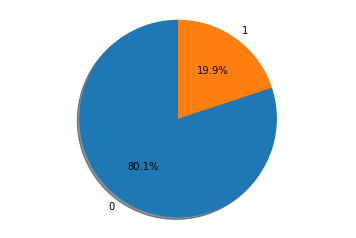

In [40]:
explore_non_numeric(application_train['FLAG_WORK_PHONE'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

Value: 0 Count: 246203 Percentage: 80.06315221244118
Value: 1 Count: 61308 Percentage: 19.93684778755882


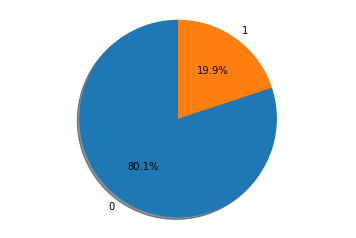

In [41]:
lb = LabelBinarizer()
bool_work_phone = lb.fit_transform(application_train['FLAG_WORK_PHONE'])

explore_non_numeric(bool_work_phone)

string_to_bool_features.append('FLAG_WORK_PHONE')

#### FLAG_PHONE
Did client provide home phone (1=YES, 0=NO)

Value: 0 Count: 221080 Percentage: 71.89336316424453
Value: 1 Count: 86431 Percentage: 28.106636835755467


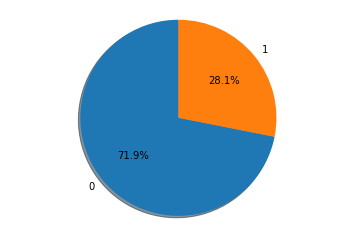

In [42]:
explore_non_numeric(application_train['FLAG_PHONE'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

Value: 0 Count: 221080 Percentage: 71.89336316424453
Value: 1 Count: 86431 Percentage: 28.106636835755467


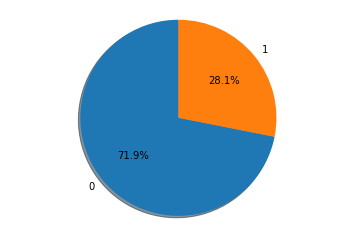

In [43]:
lb = LabelBinarizer()
bool_phone = lb.fit_transform(application_train['FLAG_PHONE'])

explore_non_numeric(bool_phone)

string_to_bool_features.append('FLAG_PHONE')

#### FLAG_EMAIL
Did client provide email (1=YES, 0=NO)

Value: 0 Count: 290069 Percentage: 94.32800777858354
Value: 1 Count: 17442 Percentage: 5.6719922214164695


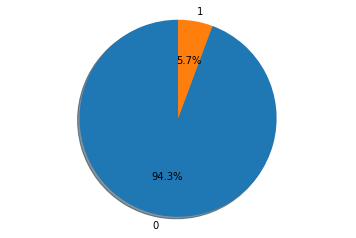

In [44]:
explore_non_numeric(application_train['FLAG_EMAIL'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

Value: 0 Count: 290069 Percentage: 94.32800777858354
Value: 1 Count: 17442 Percentage: 5.6719922214164695


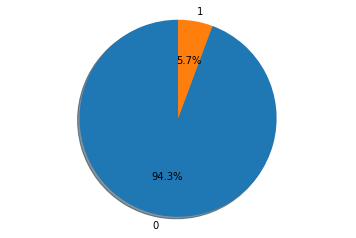

In [45]:
lb = LabelBinarizer()
bool_email = lb.fit_transform(application_train['FLAG_EMAIL'])

explore_non_numeric(bool_email)

string_to_bool_features.append('FLAG_EMAIL')

#### OCCUPATION_TYPE
Family status of the client

Value: Accountants Count: 9813 Percentage: 3.1911053588326923
Value: Cleaning staff Count: 4653 Percentage: 1.5131166039588828
Value: Cooking staff Count: 5946 Percentage: 1.9335893675348197
Value: Core staff Count: 27570 Percentage: 8.965532940285064
Value: Drivers Count: 18603 Percentage: 6.049539691263077
Value: HR staff Count: 563 Percentage: 0.1830828815879757
Value: High skill tech staff Count: 11380 Percentage: 3.7006806260589054
Value: IT staff Count: 526 Percentage: 0.17105079167899687
Value: Laborers Count: 55186 Percentage: 17.94602469505156
Value: Low-skill Laborers Count: 2093 Percentage: 0.6806260589052099
Value: Managers Count: 21371 Percentage: 6.94967009310236
Value: Medicine staff Count: 8537 Percentage: 2.776160852782502
Value: Missing Count: 96391 Percentage: 31.345545362604916
Value: Private service staff Count: 2652 Percentage: 0.8624081740165392
Value: Realty agents Count: 751 Percentage: 0.24421890599035484
Value: Sales staff Count: 32102 Percentage: 10.43930135

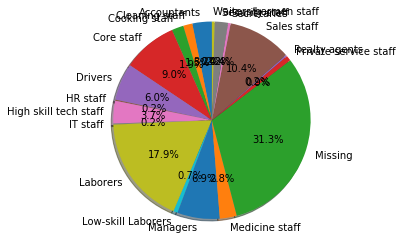

In [46]:
occupation_type = application_train['OCCUPATION_TYPE']
occupation_type = occupation_type.replace(np.nan, "Missing")

explore_non_numeric(occupation_type)

# Swap the normalized data with the original field
application_train['OCCUPATION_TYPE_NORMALIZED'] = occupation_type
result = application_train.drop('OCCUPATION_TYPE',axis=1)

#Track this for one-hot encoding later
non_numeric_features.append("OCCUPATION_TYPE");

#### CNT_FAM_MEMBERS
How many family members does client have

Max: 20.0 Min: 0.0 Mean: 2.152651449866834 Avg: 2.152651449866834 Std: 0.910693674052923


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


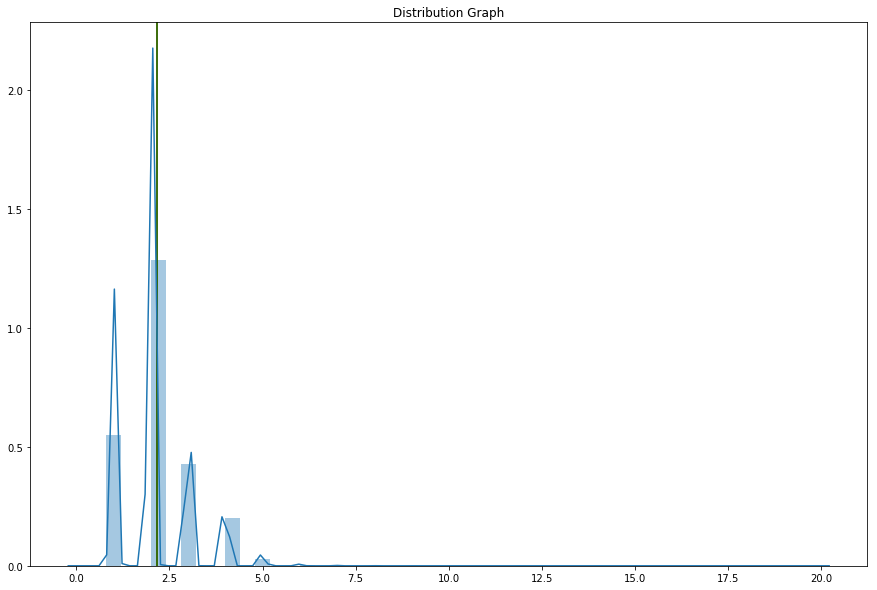

In [47]:
cnt_fam_members_numeric = np.nan_to_num(application_train['CNT_FAM_MEMBERS'])
explore_numeric(cnt_fam_members_numeric)
numeric_features.append("CNT_FAM_MEMBERS")

#### REGION_RATING_CLIENT
Our rating of the region where client lives (1,2,3)

Max: 3 Min: 1 Mean: 2.0524631639193394 Avg: 2.0524631639193394 Std: 0.5090330751472117


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


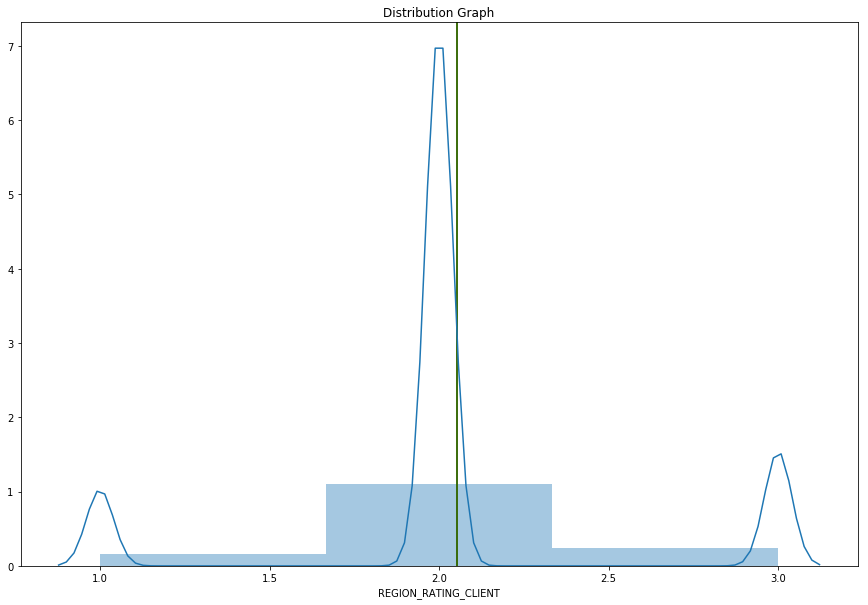

In [48]:
explore_numeric(application_train['REGION_RATING_CLIENT'], graphType="hist", bins=3)

#### REGION_RATING_CLIENT_W_CITY
Our rating of the region where client lives with taking city into account (1,2,3)

Max: 3 Min: 1 Mean: 2.031520823645333 Avg: 2.031520823645333 Std: 0.5027362154847554


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


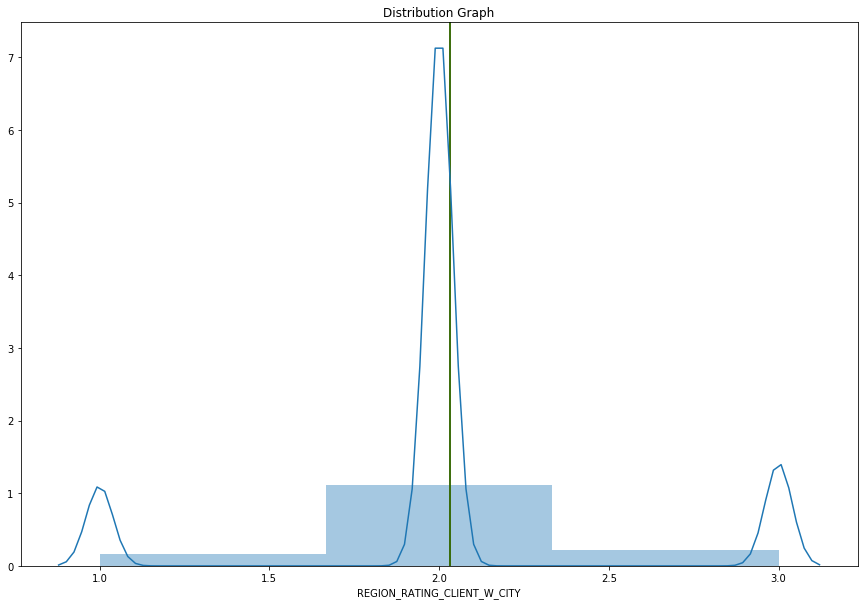

In [49]:
explore_numeric(application_train['REGION_RATING_CLIENT_W_CITY'],graphType="hist",bins=3)

#### WEEKDAY_APPR_PROCESS_START
On which day of the week did the client apply for the loan

Value: FRIDAY Count: 50338 Percentage: 16.369495725356167
Value: MONDAY Count: 50714 Percentage: 16.491767774160923
Value: SATURDAY Count: 33852 Percentage: 11.008386691858178
Value: SUNDAY Count: 16181 Percentage: 5.261925589653703
Value: THURSDAY Count: 50591 Percentage: 16.451769205004048
Value: TUESDAY Count: 53901 Percentage: 17.528153464428915
Value: WEDNESDAY Count: 51934 Percentage: 16.888501549538066


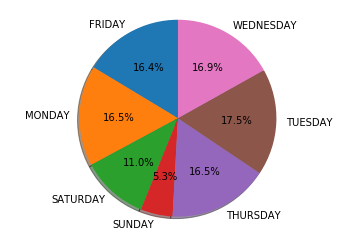

In [50]:
explore_non_numeric(application_train['WEEKDAY_APPR_PROCESS_START'])
non_numeric_features.append("WEEKDAY_APPR_PROCESS_START")

#### HOUR_APPR_PROCESS_START
Approximately at what hour did the client apply for the loan

Value: 0 Count: 40 Percentage: 0.013007664766463638
Value: 1 Count: 86 Percentage: 0.027966479247896824
Value: 2 Count: 305 Percentage: 0.09918344384428524
Value: 3 Count: 1230 Percentage: 0.39998569156875685
Value: 4 Count: 2090 Percentage: 0.6796504840477251
Value: 5 Count: 3638 Percentage: 1.183047110509868
Value: 6 Count: 5842 Percentage: 1.8997694391420146
Value: 7 Count: 9131 Percentage: 2.9693246745644872
Value: 8 Count: 15127 Percentage: 4.919173623057387
Value: 9 Count: 27384 Percentage: 8.905047299121007
Value: 10 Count: 37722 Percentage: 12.266878258013534
Value: 11 Count: 37229 Percentage: 12.10655878976687
Value: 12 Count: 34233 Percentage: 11.132284698758744
Value: 13 Count: 30959 Percentage: 10.067607337623695
Value: 14 Count: 27682 Percentage: 9.001954401631162
Value: 15 Count: 24839 Percentage: 8.077434628354759
Value: 16 Count: 20385 Percentage: 6.629031156609032
Value: 17 Count: 14900 Percentage: 4.845355125507705
Value: 18 Count: 9049 Percentage: 2.942658961793237
V

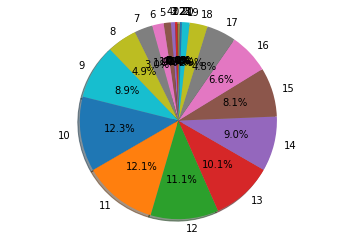

In [51]:
'''
NOTE: Although this field is an integer, it rrepresents the hour at which the application was filed.
Simply treating it as an integer would impart a higher weight to applications filed later in the day, 
which doesn't really make any sense.  

Instead, I'm treating them as 24 separate categories and one-hot encoding them. 

This should ensure that the application time is considered, but not arbitrarily weighted.
'''
explore_non_numeric(application_train['HOUR_APPR_PROCESS_START'])
non_numeric_features.append("HOUR_APPR_PROCESS_START")

#### REG_REGION_NOT_LIVE_REGION
Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)

Value: 0 Count: 302854 Percentage: 98.48558262956448
Value: 1 Count: 4657 Percentage: 1.514417370435529


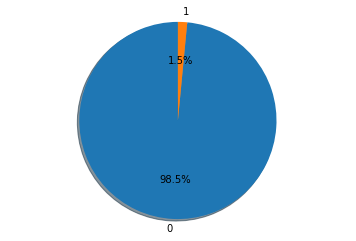

In [52]:
explore_non_numeric(application_train['REG_REGION_NOT_LIVE_REGION'])

#### REG_REGION_NOT_WORK_REGION
Flag if client's permanent address does not match work address (1=different, 0=same, at region level)

Value: 0 Count: 291899 Percentage: 94.92310844164923
Value: 1 Count: 15612 Percentage: 5.076891558350758


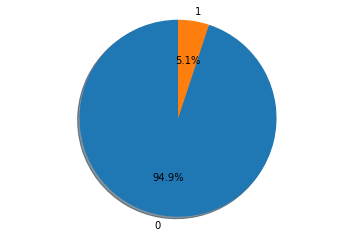

In [53]:
explore_non_numeric(application_train['REG_REGION_NOT_WORK_REGION'])

#### LIVE_REGION_NOT_WORK_REGION
Flag if client's contact address does not match work address (1=different, 0=same, at region level)

Value: 0 Count: 295008 Percentage: 95.93412918562262
Value: 1 Count: 12503 Percentage: 4.065870814377372


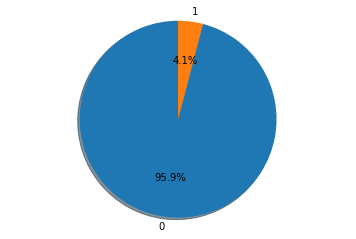

In [54]:
explore_non_numeric(application_train['LIVE_REGION_NOT_WORK_REGION'])

#### REG_CITY_NOT_LIVE_CITY
Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)

Value: 0 Count: 283472 Percentage: 92.18271866697452
Value: 1 Count: 24039 Percentage: 7.817281333025486


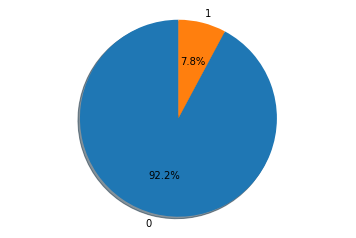

In [55]:
explore_non_numeric(application_train['REG_CITY_NOT_LIVE_CITY'])

#### REG_CITY_NOT_WORK_CITY
Flag if client's permanent address does not match work address (1=different, 0=same, at city level)

Value: 0 Count: 236644 Percentage: 76.95464552487553
Value: 1 Count: 70867 Percentage: 23.045354475124466


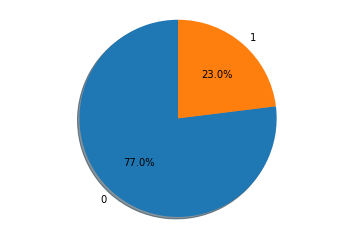

In [56]:
explore_non_numeric(application_train['REG_CITY_NOT_WORK_CITY'])

#### LIVE_CITY_NOT_WORK_CITY
Flag if client's contact address does not match work address (1=different, 0=same, at city level)

Value: 0 Count: 252296 Percentage: 82.04454474799276
Value: 1 Count: 55215 Percentage: 17.955455252007248


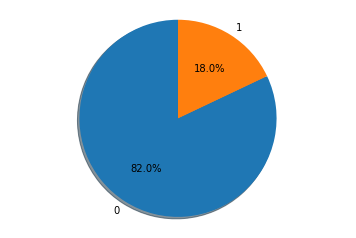

In [57]:
explore_non_numeric(application_train['LIVE_CITY_NOT_WORK_CITY'])

#### ORGANIZATION_TYPE
Type of organization where client works

Value: Advertising Count: 429 Percentage: 0.13950720462032254
Value: Agriculture Count: 2454 Percentage: 0.7980202334225442
Value: Bank Count: 2507 Percentage: 0.8152553892381086
Value: Business Entity Type 1 Count: 5984 Percentage: 1.9459466490629604
Value: Business Entity Type 2 Count: 10553 Percentage: 3.4317471570122695
Value: Business Entity Type 3 Count: 67992 Percentage: 22.110428570034895
Value: Cleaning Count: 260 Percentage: 0.08454982098201365
Value: Construction Count: 6721 Percentage: 2.185612872385053
Value: Culture Count: 379 Percentage: 0.12324762366224297
Value: Electricity Count: 950 Percentage: 0.3089320382035114
Value: Emergency Count: 560 Percentage: 0.18210730673049094
Value: Government Count: 10404 Percentage: 3.383293605757193
Value: Hotel Count: 966 Percentage: 0.3141351041100969
Value: Housing Count: 2958 Percentage: 0.9619168094799861
Value: Industry: type 1 Count: 1039 Percentage: 0.33787409230889304
Value: Industry: type 10 Count: 109 Percentage: 0.03544588

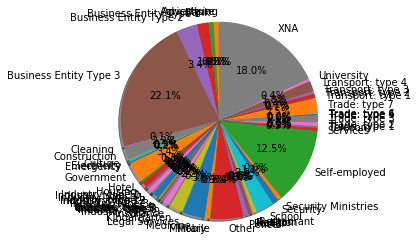

In [58]:
explore_non_numeric(application_train['ORGANIZATION_TYPE'])

# Keep track for one-hot encoding later
non_numeric_features.append("ORGANIZATION_TYPE")

#### FONDKAPREMONT_MODE
Not sure - Described as "normalized"

In [ ]:
#explore_non_numeric(application_train['FONDKAPREMONT_MODE'])
application_train['FONDKAPREMONT_MODE'] = application_train['FONDKAPREMONT_MODE'].replace({np.nan: "not specified"})

explore_non_numeric(application_train['FONDKAPREMONT_MODE'])

# Keep track for one-hot encoding later
non_numeric_features.append("FONDKAPREMONT_MODE")

#### EMERGENCYSTATE_MODE
Not sure - Described as "normalized"

In [ ]:
#explore_non_numeric(application_train['FONDKAPREMONT_MODE'])
application_train['EMERGENCYSTATE_MODE'] = application_train['EMERGENCYSTATE_MODE'].replace({np.nan: "not specified"})

explore_non_numeric(application_train['EMERGENCYSTATE_MODE'])

# Keep track for one-hot encoding later
non_numeric_features.append("EMERGENCYSTATE_MODE")

#### HOUSETYPE_MODE
Not sure - Described as "normalized"

In [ ]:
application_train['HOUSETYPE_MODE'] = application_train['HOUSETYPE_MODE'].replace({np.nan: "not specified"})

explore_non_numeric(application_train['HOUSETYPE_MODE'])

# Keep track for one-hot encoding later
non_numeric_features.append("HOUSETYPE_MODE")

#### WALLSMATERIAL_MODE
Not sure - Described as "normalized"

In [ ]:
application_train['WALLSMATERIAL_MODE'] = application_train['WALLSMATERIAL_MODE'].replace({np.nan: "not specified"})

explore_non_numeric(application_train['WALLSMATERIAL_MODE'])

# Keep track for one-hot encoding later
non_numeric_features.append("WALLSMATERIAL_MODE")

#### EXT_SOURCE_1
Normalized score from external data source

In [ ]:
ext_source_1 = np.nan_to_num(application_train['EXT_SOURCE_1'])
explore_numeric(ext_source_1)

#### EXT_SOURCE_2
Normalized score from external data source

In [ ]:
ext_source_2 = np.nan_to_num(application_train['EXT_SOURCE_2'])
explore_numeric(ext_source_1)

#### EXT_SOURCE_3
Normalized score from external data source

In [ ]:
ext_source_3 = np.nan_to_num(application_train['EXT_SOURCE_3'])
explore_numeric(ext_source_3)

#### APARTMENTS_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
apartments_avg = np.nan_to_num(application_train['APARTMENTS_AVG'])
explore_numeric(apartments_avg)

#### BASEMENTAREA_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
basementarea_avg = np.nan_to_num(application_train['BASEMENTAREA_AVG'])
explore_numeric(basementarea_avg)

#### YEARS_BEGINEXPLUATATION_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
years_beginexpluatation_avg = np.nan_to_num(application_train['YEARS_BEGINEXPLUATATION_AVG'])
explore_numeric(years_beginexpluatation_avg)

#### YEARS_BUILD_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
years_build_avg = np.nan_to_num(application_train['YEARS_BUILD_AVG'])
explore_numeric(years_build_avg)

#### COMMONAREA_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
commonarea_avg = np.nan_to_num(application_train['COMMONAREA_AVG'])
explore_numeric(commonarea_avg)

#### ELEVATORS_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
elevators_avg = np.nan_to_num(application_train['ELEVATORS_AVG'])
explore_numeric(elevators_avg)

#### ENTRANCES_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
entrances_avg = np.nan_to_num(application_train['ENTRANCES_AVG'])
explore_numeric(entrances_avg)

#### FLOORSMAX_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
floorsmax_avg = np.nan_to_num(application_train['FLOORSMAX_AVG'])
explore_numeric(floorsmax_avg)

#### FLOORSMIN_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
floorsmin_avg = np.nan_to_num(application_train['FLOORSMIN_AVG'])
explore_numeric(floorsmin_avg)

#### LANDAREA_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
landarea_avg = np.nan_to_num(application_train['LANDAREA_AVG'])
explore_numeric(landarea_avg)

#### LIVINGAPARTMENTS_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
livingapartments_avg = np.nan_to_num(application_train['LIVINGAPARTMENTS_AVG'])
explore_numeric(livingapartments_avg)

#### LIVINGAREA_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
livingarea_avg = np.nan_to_num(application_train['LIVINGAREA_AVG'])
explore_numeric(livingarea_avg)

### Note: It looks like these cells are well-normalized and usable as-is.  Skipping the remainder of the normalized housing stats.

#### OBS_30_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings with observable 30 DPD (days past due) default

In [ ]:
obs_30 = np.nan_to_num(application_train['OBS_30_CNT_SOCIAL_CIRCLE'])
explore_numeric(obs_30)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
obs_30 = pd.DataFrame(data=obs_30)
obs_30_transformed = obs_30.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(obs_30_transformed, showMeanLines=False)

log_transform_features.append('OBS_30_CNT_SOCIAL_CIRCLE')

#### DEF_30_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings defaulted on 30 DPD (days past due)

In [ ]:
def_30 = np.nan_to_num(application_train['DEF_30_CNT_SOCIAL_CIRCLE'])
explore_numeric(def_30)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
# We need it to be a DataFrame column
def_30 = pd.DataFrame(data=def_30)

# Select the column with the actual data
def_30 =  def_30[0]

# Apply a log transformation
def_30_transformed = def_30.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(def_30_transformed)

numeric_features.append('DEF_30_CNT_SOCIAL_CIRCLE')
#log_transform_features.append('DEF_30_CNT_SOCIAL_CIRCLE')

#### OBS_60_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings with observable 30 DPD (days past due) default

In [ ]:
obs_60 = np.nan_to_num(application_train['OBS_60_CNT_SOCIAL_CIRCLE'])
explore_numeric(obs_60)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
# We need it to be a DataFrame column
obs_60 = pd.DataFrame(data=obs_60)

# Select the column in the DataFrame with the actual data
obs_60 = obs_60[0]

obs_60_transformed = obs_60.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(obs_60_transformed, showMeanLines=False)

numeric_features.append('OBS_60_CNT_SOCIAL_CIRCLE')
#log_transform_features.append('OBS_60_CNT_SOCIAL_CIRCLE')

#### DEF_60_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings defaulted on 60 DPD (days past due)

In [ ]:
def_60 = np.nan_to_num(application_train['DEF_60_CNT_SOCIAL_CIRCLE'])
explore_numeric(def_60)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
# We need it to be a DataFrame column
def_60 = pd.DataFrame(data=def_60)

# Select the column in the DataFrame with the actual data
def_60 = def_60[0]

def_60_transformed = def_60.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(def_60_transformed)

numeric_features.append('DEF_60_CNT_SOCIAL_CIRCLE')
#log_transform_features.append('DEF_60_CNT_SOCIAL_CIRCLE')

#### DAYS_LAST_PHONE_CHANGE
How many days before application did client change phone

In [ ]:
days = np.nan_to_num(application_train['DAYS_LAST_PHONE_CHANGE'])
explore_numeric(days)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
days = pd.DataFrame(data=days)

# Select the column in the DataFrame with the actual data
days = days[0]

# Negative numbers are undefined for log, so offset them into the positive range
min = np.min(days)
offset = 2 * abs(min)

days_transformed = days.apply(lambda x: np.log(x + offset + 1))

#visualize the new distribution
explore_numeric(np.nan_to_num(days_transformed), showMeanLines=False)

numeric_features.append('DAYS_LAST_PHONE_CHANGE')
#log_transform_features.append('DAYS_LAST_PHONE_CHANGE')

#### AMT_REQ_CREDIT_BUREAU_HOUR
Number of enquiries to Credit Bureau about the client one hour before application

In [ ]:
hour = np.nan_to_num(application_train['AMT_REQ_CREDIT_BUREAU_HOUR'])
explore_numeric(hour)
numeric_features.append("AMT_REQ_CREDIT_BUREAU_HOUR")

#### AMT_REQ_CREDIT_BUREAU_DAY
Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)

In [ ]:
day = np.nan_to_num(application_train['AMT_REQ_CREDIT_BUREAU_DAY'])
explore_numeric(day)
numeric_features.append("AMT_REQ_CREDIT_BUREAU_DAY")

#### AMT_REQ_CREDIT_BUREAU_WEEK
Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application)

In [ ]:
hour = np.nan_to_num(application_train['AMT_REQ_CREDIT_BUREAU_WEEK'])
explore_numeric(hour)
numeric_features.append("AMT_REQ_CREDIT_BUREAU_WEEK")

#### AMT_REQ_CREDIT_BUREAU_MONTH
Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)

In [ ]:
month = np.nan_to_num(application_train['AMT_REQ_CREDIT_BUREAU_MON'])
explore_numeric(month)
numeric_features.append("AMT_REQ_CREDIT_BUREAU_MON")

#### AMT_REQ_CREDIT_BUREAU_QRT
Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)

In [ ]:
qrt = np.nan_to_num(application_train['AMT_REQ_CREDIT_BUREAU_QRT'])
explore_numeric(qrt)
numeric_features.append("AMT_REQ_CREDIT_BUREAU_QRT")

#### AMT_REQ_CREDIT_BUREAU_YEAR
Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)

In [ ]:
year = np.nan_to_num(application_train['AMT_REQ_CREDIT_BUREAU_YEAR'])
explore_numeric(year)
numeric_features.append("AMT_REQ_CREDIT_BUREAU_YEAR")



#### FLAG_DOCUMENT_4 - 21
Did client provide document 4

In [ ]:
print("Document 2")
explore_non_numeric(application_train['FLAG_DOCUMENT_2'])

print("Document 3")
explore_non_numeric(application_train['FLAG_DOCUMENT_3'])

print("Document 4")
explore_non_numeric(application_train['FLAG_DOCUMENT_4'])

print("Document 5")
explore_non_numeric(application_train['FLAG_DOCUMENT_5'])

print("Document 6")
explore_non_numeric(application_train['FLAG_DOCUMENT_6'])

print("Document 7")
explore_non_numeric(application_train['FLAG_DOCUMENT_7'])

print("Document 8")
explore_non_numeric(application_train['FLAG_DOCUMENT_8'])

print("Document 9")
explore_non_numeric(application_train['FLAG_DOCUMENT_9'])

print("Document 10")
explore_non_numeric(application_train['FLAG_DOCUMENT_10'])

print("Document 11")
explore_non_numeric(application_train['FLAG_DOCUMENT_11'])

print("Document 12")
explore_non_numeric(application_train['FLAG_DOCUMENT_12'])

print("Document 13")
explore_non_numeric(application_train['FLAG_DOCUMENT_13'])

print("Document 14")
explore_non_numeric(application_train['FLAG_DOCUMENT_14'])

print("Document 15")
explore_non_numeric(application_train['FLAG_DOCUMENT_15'])

print("Document 16")
explore_non_numeric(application_train['FLAG_DOCUMENT_16'])

print("Document 17")
explore_non_numeric(application_train['FLAG_DOCUMENT_17'])

print("Document 18")
explore_non_numeric(application_train['FLAG_DOCUMENT_18'])

print("Document 19")
explore_non_numeric(application_train['FLAG_DOCUMENT_19'])

print("Document 20")
explore_non_numeric(application_train['FLAG_DOCUMENT_20'])

print("Document 21")
explore_non_numeric(application_train['FLAG_DOCUMENT_21'])

In [ ]:
# Add some more "normalized" fields for numeric processing
numeric_features.append("APARTMENTS_AVG")
numeric_features.append("APARTMENTS_MEDI")
numeric_features.append("APARTMENTS_MODE")
numeric_features.append("BASEMENTAREA_AVG")
numeric_features.append("BASEMENTAREA_MEDI")
numeric_features.append("BASEMENTAREA_MODE")
numeric_features.append("COMMONAREA_AVG")
numeric_features.append("COMMONAREA_MEDI")
numeric_features.append("COMMONAREA_MODE")
numeric_features.append("ELEVATORS_AVG")
numeric_features.append("ELEVATORS_MEDI")
numeric_features.append("ELEVATORS_MODE")
numeric_features.append("ENTRANCES_AVG")
numeric_features.append("ENTRANCES_MEDI")
numeric_features.append("ENTRANCES_MODE")
numeric_features.append("EXT_SOURCE_1")
numeric_features.append("EXT_SOURCE_2")
numeric_features.append("EXT_SOURCE_3")
numeric_features.append("FLOORSMAX_AVG")
numeric_features.append("FLOORSMAX_MEDI")
numeric_features.append("FLOORSMAX_MODE")
numeric_features.append("FLOORSMIN_AVG")
numeric_features.append("FLOORSMIN_MEDI")
numeric_features.append("FLOORSMIN_MODE")
numeric_features.append("LANDAREA_AVG")
numeric_features.append("LANDAREA_MEDI")
numeric_features.append("LANDAREA_MODE")
numeric_features.append("LANDAREA_AVG")
numeric_features.append("LANDAREA_MEDI")
numeric_features.append("LANDAREA_MODE")
numeric_features.append("LIVINGAPARTMENTS_AVG")
numeric_features.append("LIVINGAPARTMENTS_MEDI")
numeric_features.append("LIVINGAPARTMENTS_MODE")
numeric_features.append("LIVINGAREA_AVG")
numeric_features.append("LIVINGAREA_MEDI")
numeric_features.append("LIVINGAREA_MODE")
numeric_features.append("NONLIVINGAPARTMENTS_AVG")
numeric_features.append("NONLIVINGAPARTMENTS_MEDI")
numeric_features.append("NONLIVINGAPARTMENTS_MODE")
numeric_features.append("NONLIVINGAREA_AVG")
numeric_features.append("NONLIVINGAREA_MEDI")
numeric_features.append("NONLIVINGAREA_MODE")
numeric_features.append("TOTALAREA_MODE")
numeric_features.append("YEARS_BEGINEXPLUATATION_AVG")
numeric_features.append("YEARS_BEGINEXPLUATATION_MEDI")
numeric_features.append("YEARS_BEGINEXPLUATATION_MODE")
numeric_features.append("YEARS_BUILD_AVG")
numeric_features.append("YEARS_BUILD_MEDI")
numeric_features.append("YEARS_BUILD_MODE")

### Analysis
Now that we've sanity-checked the fields, let's take a deeper look at what we have.

In [ ]:
# Calculate which features correlate most strongly to the TARGET variable
correlations = application_train.corr()['TARGET'].sort_values()

In [ ]:
strong_correlations = correlations[:10]

# We want to omit TARGET, which is always the last record... 
strong_correlations = strong_correlations.append(correlations[-10:-1])  

In [ ]:
#display(correlations)
display(strong_correlations)

Positive values are more closely tied to failure to repay the loan.  Negative values are more closely tied to successful repayments.

### Looking at  Age vs. Repayment
Age is strongly closely correlated with failure to repay.  People that have payment problems trend a few years younger. Not super surprising.

In [ ]:
# Age is represented as a negative integers of days before the application date.
# The absolute value divided by 365 should give us age in years... 

# The average age of someone who pays on time
avg_good = np.average(abs(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'])) / 365

# The average age of someone who defaults
avg_bad = np.average(abs(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'])) / 365

# Examine distribution
plt.figure(figsize=(15,10))
plt.title("Age Distribution in Years")
plt.axvline(avg_good, color="blue")    # Plot the average
plt.axvline(avg_bad, color="orange") # Plot the mean

sns.kdeplot(abs(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH']) / 365, label = "Paid As Expected", shade=True)
sns.kdeplot(abs(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH']) / 365, label = "Payment Problems", shade=True)

print("Average age of someone who defaults: {0}  Avg age of someone who pays: {1}".format(avg_bad, avg_good))

### Employment Length vs Repayment

In [ ]:
# DAYS_EMPLOYED is represented as a negative integers of days before the application date.
# The absolute value divided by 365 should give us age in years... 

# The average age of someone who pays on time
avg_good = np.average(abs(application_train.loc[application_train['TARGET'] == 0, 'DAYS_EMPLOYED'])) / 365

# The average age of someone who defaults
avg_bad = np.average(abs(application_train.loc[application_train['TARGET'] == 1, 'DAYS_EMPLOYED'])) / 365

# Examine distribution
plt.figure(figsize=(15,10))
plt.title("Employment in Years")
plt.axvline(avg_good, color="blue")    # Plot the average
plt.axvline(avg_bad, color="orange") # Plot the mean

sns.kdeplot(abs(application_train.loc[application_train['TARGET'] == 0, 'DAYS_EMPLOYED']) / 365, label = "Paid As Expected", shade=True)
sns.kdeplot(abs(application_train.loc[application_train['TARGET'] == 1, 'DAYS_EMPLOYED']) / 365, label = "Payment Problems", shade=True)

print("Average employment of someone who defaults: {0}  Avg employment of someone who pays: {1}".format(avg_bad, avg_good))

NOTE: There's a large section of the population that has an impossibly high tenure (~1000 years).  This is clearly problematic, and should probably handle it differently.

### Output

Output lists of fields that need transformation for consumption by the preprocessing script

In [ ]:
non_numeric_features = pd.DataFrame({'features':non_numeric_features})
numeric_features = pd.DataFrame({'features':numeric_features})
string_to_bool_features = pd.DataFrame({'features':string_to_bool_features})
log_transform_features = pd.DataFrame({'features':log_transform_features})
strong_correlations = pd.DataFrame({'features':strong_correlations})

non_numeric_features.to_csv('data/tmp/non_numeric_features.csv')
numeric_features.to_csv('data/tmp/numeric_features.csv')
string_to_bool_features.to_csv('data/tmp/string_to_bool.csv')
log_transform_features.to_csv('data/tmp/log_transform.csv')
strong_correlations.to_csv('data/tmp/application_strong_correlations.csv')